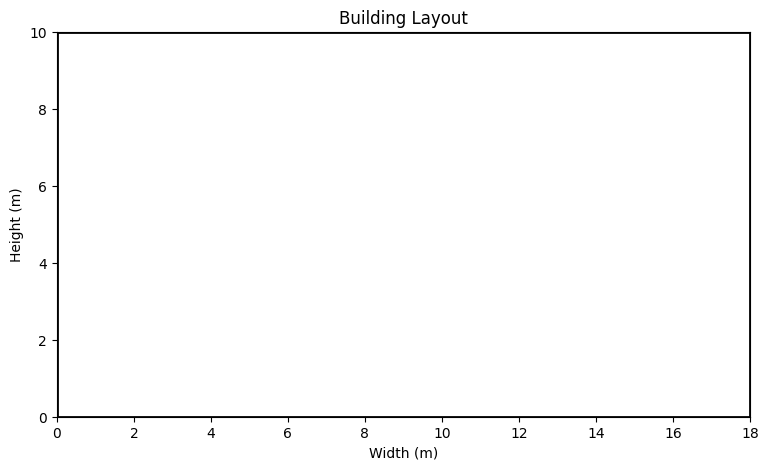

In [83]:
import matplotlib.pyplot as plt

def draw_building(width, height):
    """A simple rectangular building layout"""
    fig, ax = plt.subplots(figsize=(width / 2, height / 2))
    # Draw building boundary
    ax.plot([0, width, width, 0, 0], [0, 0, height, height, 0], 'k-', linewidth=2)
    # Axes limits and aspect
    ax.set(xlim=(0, width), ylim=(0, height), aspect='equal')
    # Labels and title
    ax.set(xlabel='Width (m)', ylabel='Height (m)', title='Building Layout')
    return ax

# Example usage
ax = draw_building(18, 10)
plt.show()

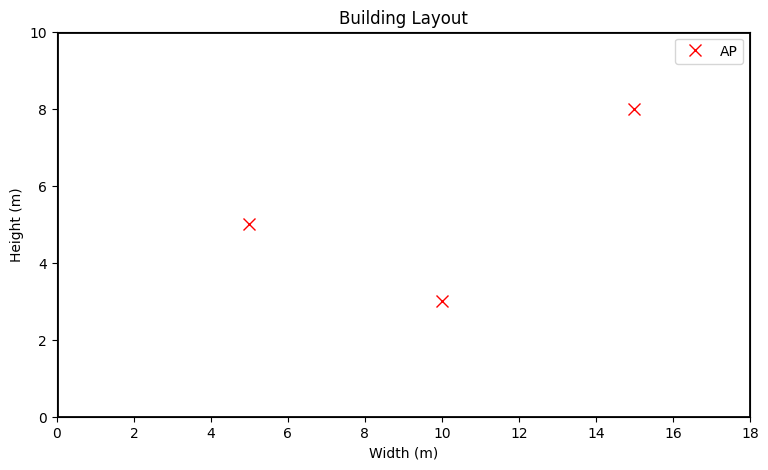

In [117]:
def place_access_points(ax, access_points=[]):
    """Manual placement of Access Points (APs) uisng coordinates"""
    for i, ap in enumerate(access_points):
        ax.plot(ap[0], ap[1], 'rx', markersize=8, label='AP' if i == 0 else "")
    ax.legend()
    plt.show()

    return access_points


# Example usage
ax = draw_building(18, 10)
ap = place_access_points(ax, [(5, 5), (10, 3), (15, 8)])
plt.show()

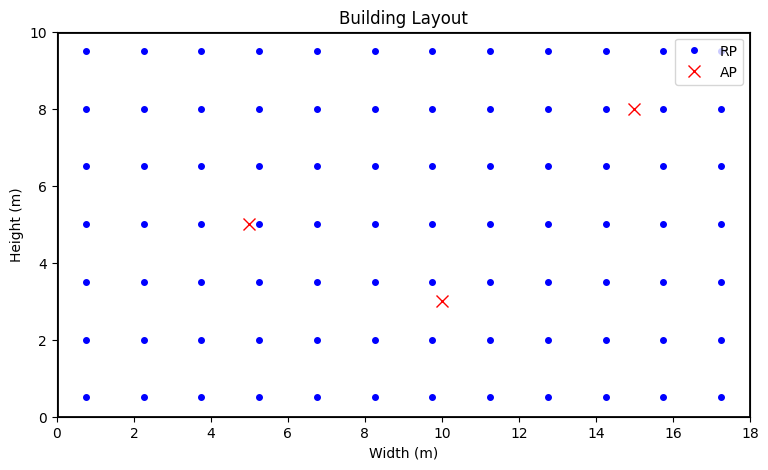

In [123]:
import numpy as np

def place_reference_points(ax, length, width, spacing):
    """Symmetric placement of Reference Points (RPs) using meshgrid"""
    # Step 1: Compute distance from walls and number of RPs
    d_wx = (length % spacing) / 2
    n_RPx = length // spacing + 1

    d_wy = (width % spacing) / 2
    n_RPy = width // spacing + 1

    # Step 2: Adjust if RPs fall exactly on the wall
    if d_wx == 0:
        d_wx = spacing / 2
        n_RPx -= 1

    if d_wy == 0:
        d_wy = spacing / 2
        n_RPy -= 1

    # Step 3: Create X and Y coordinate arrays
    X = [d_wx + i * spacing for i in range(int(n_RPx))]
    Y = [d_wy + i * spacing for i in range(int(n_RPy))]

    # Step 4: Create meshgrid and flatten to list of coordinates
    XX, YY = np.meshgrid(X, Y)
    rp = np.column_stack((XX.ravel(), YY.ravel()))

    # Plot RPs
    for i, (x, y) in enumerate(rp):
        ax.plot(x, y, 'bo', markersize=4, label='RP' if i == 0 else "")
    ax.legend()

    return rp


# Example usage
ax = draw_building(18, 10)
rp = place_reference_points(ax, 18, 10, 1.5)
ap = place_access_points(ax, [(5, 5), (10, 3), (15, 8)])
plt.show()

In [136]:
import pandas as pd

def simulate_rss(aps, rps, p_tx=-20, path_loss_exponent=2, noise_std=2):

    """
    Simulates RSS values from APs for all RPs using the path loss formula.
    Path loss formula to simulate RSS values in dBm
    Formula: RSS = P_tx - 10 * PLE * log10(distance) + noise
      Where:
    - P_tx is the transmit power in dBm (default 20 dBm)
    - PLE is the Path Loss Exponent (default 2 for free-space conditions)
    - distance is the Euclidean distance between AP and RP
    - noise is random Gaussian noise with a standard deviation (default 2 dB)
    """

    rss_matrix = []

    for rp in rps:
        row = []
        for ap in aps:
            distance = np.linalg.norm(np.array(ap) - np.array(rp))
            if distance == 0:
                rss = p_tx
            else:
                rss = p_tx - 10 * path_loss_exponent * np.log10(distance)
            rss += np.random.normal(0, noise_std)
            row.append(rss)
        rss_matrix.append(row)

    return np.round(np.array(rss_matrix), 2)  # Round RSS values to 2 decimals

rss_matrix = simulate_rss(ap, rp)

# Create dataframe with RP coords and RSS values
df = pd.DataFrame(rss_matrix, columns=[f'AP_{i+1}' for i in range(len(ap))])
df.insert(0, 'RP_Y', rp[:, 1])
df.insert(0, 'RP_X', rp[:, 0])

# Export to CSV
csv_filename = 'rss_values.csv'
df.to_csv(csv_filename)

print(f"Exported RSS data to '{csv_filename}'. Here are first rows:")
print(df.head(10))


Exported RSS data to 'rss_values.csv'. Here are first rows:
    RP_X  RP_Y   AP_1   AP_2   AP_3
0   0.75   0.5 -35.52 -39.96 -46.86
1   2.25   0.5 -32.62 -39.48 -42.74
2   3.75   0.5 -29.60 -38.24 -41.18
3   5.25   0.5 -33.84 -31.80 -38.97
4   6.75   0.5 -36.31 -27.82 -40.78
5   8.25   0.5 -34.71 -28.91 -40.79
6   9.75   0.5 -33.35 -28.31 -38.12
7  11.25   0.5 -34.91 -31.08 -38.01
8  12.75   0.5 -40.76 -31.26 -37.81
9  14.25   0.5 -40.19 -38.59 -39.94


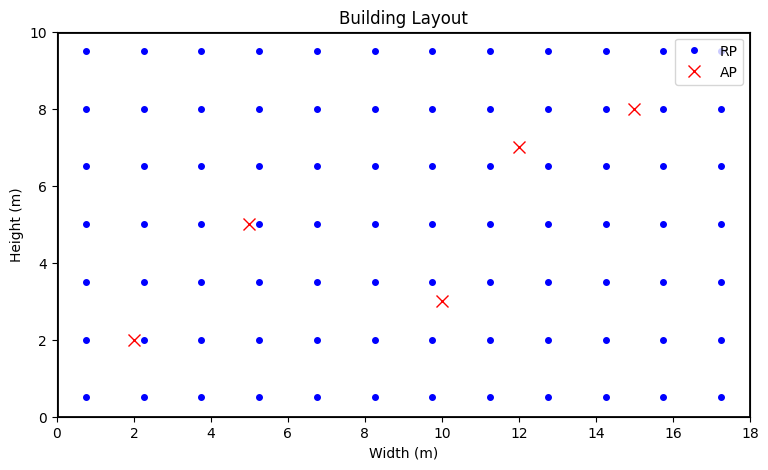

Exported RSS data to 'rss_values_2.csv'. Here are the first rows:
    RP_X  RP_Y   AP_1   AP_2   AP_3   AP_4   AP_5
0   0.75   0.5 -24.75 -37.31 -42.25 -44.26 -46.97
1   2.25   0.5 -18.86 -35.26 -40.29 -42.28 -40.20
2   3.75   0.5 -26.13 -32.22 -33.86 -37.41 -40.84
3   5.25   0.5 -34.25 -33.68 -34.51 -44.39 -40.19
4   6.75   0.5 -36.49 -30.77 -34.44 -39.05 -38.94
5   8.25   0.5 -34.90 -33.36 -27.74 -38.31 -36.49
6   9.75   0.5 -38.28 -34.51 -29.74 -39.72 -39.12
7  11.25   0.5 -38.58 -40.83 -30.12 -32.89 -41.11
8  12.75   0.5 -40.10 -39.61 -32.64 -37.20 -38.30
9  14.25   0.5 -40.42 -40.84 -32.76 -35.75 -41.53


In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def draw_building(width, height):
    """A simple rectangular building layout"""
    fig, ax = plt.subplots(figsize=(width / 2, height / 2))
    # Draw building boundary
    ax.plot([0, width, width, 0, 0], [0, 0, height, height, 0], 'k-', linewidth=2)
    # Axes limits and aspect
    ax.set(xlim=(0, width), ylim=(0, height), aspect='equal')
    # Labels and title
    ax.set(xlabel='Width (m)', ylabel='Height (m)', title='Building Layout')
    return ax

def place_access_points(ax, access_points=[]):
    """Manual placement of Access Points (APs) using coordinates"""
    for i, ap in enumerate(access_points):
        ax.plot(ap[0], ap[1], 'rx', markersize=8, label='AP' if i == 0 else "")
    ax.legend()
    # Don't call plt.show() here so user can control when to display
    return access_points

def place_reference_points(ax, length, width, spacing):
    """Symmetric placement of Reference Points (RPs) using meshgrid"""
    # Step 1: Compute distance from walls and number of RPs
    d_wx = (length % spacing) / 2
    n_RPx = length // spacing + 1

    d_wy = (width % spacing) / 2
    n_RPy = width // spacing + 1

    # Step 2: Adjust if RPs fall exactly on the wall
    if d_wx == 0:
        d_wx = spacing / 2
        n_RPx -= 1

    if d_wy == 0:
        d_wy = spacing / 2
        n_RPy -= 1

    # Step 3: Create X and Y coordinate arrays
    X = [d_wx + i * spacing for i in range(int(n_RPx))]
    Y = [d_wy + i * spacing for i in range(int(n_RPy))]

    # Step 4: Create meshgrid and flatten to list of coordinates
    XX, YY = np.meshgrid(X, Y)
    rp = np.column_stack((XX.ravel(), YY.ravel()))

    # Plot RPs
    for i, (x, y) in enumerate(rp):
        ax.plot(x, y, 'bo', markersize=4, label='RP' if i == 0 else "")
    ax.legend()
    return rp

def simulate_rss(aps, rps, p_tx=-20, path_loss_exponent=2, noise_std=2):
    """
    Simulates RSS values from APs for all RPs using the path loss formula.
    RSS = P_tx - 10 * PLE * log10(distance) + noise
    """
    rss_matrix = []

    for rp in rps:
        row = []
        for ap in aps:
            distance = np.linalg.norm(np.array(ap) - np.array(rp))
            if distance == 0:
                rss = p_tx
            else:
                rss = p_tx - 10 * path_loss_exponent * np.log10(distance)
            rss += np.random.normal(0, noise_std)
            row.append(rss)
        rss_matrix.append(row)

    return np.round(np.array(rss_matrix), 2)  # Round RSS values to 2 decimals

def main():
    # Parameters
    building_length = 18
    building_width = 10
    rp_spacing = 1.5
    access_points_coords = [(2, 2), (5, 5), (10, 3), (12, 7), (15, 8)]

    # Draw building and plot points
    ax = draw_building(building_length, building_width)
    rp = place_reference_points(ax, building_length, building_width, rp_spacing)
    ap = place_access_points(ax, access_points_coords)
    plt.show()

    # Simulate RSS
    rss_matrix = simulate_rss(ap, rp)

    # Create DataFrame with RP coords and RSS values
    df = pd.DataFrame(rss_matrix, columns=[f'AP_{i+1}' for i in range(len(ap))])
    df.insert(0, 'RP_Y', rp[:, 1])
    df.insert(0, 'RP_X', rp[:, 0])

    # Export to CSV
    csv_filename = 'rss_values_2.csv'
    df.to_csv(csv_filename, index=False)

    print(f"Exported RSS data to '{csv_filename}'. Here are the first rows:")
    print(df.head(10))

if __name__ == "__main__":
    main()


In [150]:
import numpy as np

def generate_test_points(length, width, rps, test_ratio=0.2, min_distance=0.5):
    """
    Generate spatially distributed test points inside the building.

    Parameters:
    - length, width: dimensions of the building (meters)
    - rps: numpy array of shape (num_RPs, 2), coordinates of reference points
    - test_ratio: ratio of test points to total RPs (default 20%)
    - min_distance: minimum distance between any test point and any RP (meters)

    Returns:
    - test_points: numpy array of shape (num_test_points, 2)
    """
    num_rps = rps.shape[0]
    num_test_points = max(1, int(num_rps * test_ratio))  # at least one test point

    test_points = []

    while len(test_points) < num_test_points:
        # Generate random point inside building
        x = np.random.uniform(0, length)
        y = np.random.uniform(0, width)
        candidate = np.array([x, y])

        # Check distance to all RPs
        distances = np.linalg.norm(rps - candidate, axis=1)
        if np.all(distances >= min_distance):
            # Also check distance to existing test points
            if test_points:
                test_dists = np.linalg.norm(np.array(test_points) - candidate, axis=1)
                if np.any(test_dists < min_distance):
                    continue

            test_points.append(candidate)

    return np.array(test_points)

# Example usage
length = 18
width = 10

# Dummy RPs example — replace with your actual RP array
x_rps = np.arange(0.75, length, 1.5)
y_rps = np.arange(0.75, width, 1.5)
XX, YY = np.meshgrid(x_rps, y_rps)
rps = np.column_stack((XX.ravel(), YY.ravel()))

test_points = generate_test_points(length, width, rps, test_ratio=0.2, min_distance=0.5)
print("Generated test points:\n", test_points)


Generated test points:
 [[ 1.50337803  6.89065808]
 [ 6.21294622  0.06280316]
 [ 3.43118174  9.08060143]
 [ 4.08072262  6.25542629]
 [16.90004183  6.08375879]
 [ 4.62853062  6.45091586]
 [ 7.1011227   0.04723987]
 [10.15800351  2.61744507]
 [16.39771688  7.00986584]
 [ 2.41685774  7.41052591]
 [ 4.50819302  3.46401739]
 [ 1.83627711  1.28066994]
 [ 5.44424576  2.7984827 ]
 [14.352039    5.8803307 ]
 [15.11888348  4.79305927]
 [10.79150701  9.40868973]]


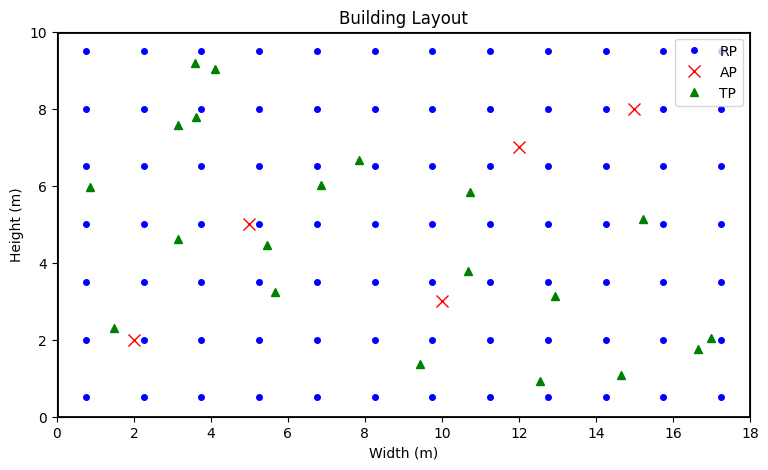

Exported Test RSS data to 'test_rss_values.csv'. Sample rows:
        TP_X      TP_Y   AP_1   AP_2   AP_3   AP_4   AP_5
0   6.867182  6.006676 -36.02 -28.65 -31.11 -36.81 -38.04
1  16.662143  1.755445 -47.24 -44.32 -36.23 -35.45 -35.86
2  12.943897  3.129302 -41.06 -38.84 -32.34 -33.45 -35.39
3  10.677194  3.797257 -36.84 -34.59 -23.92 -30.15 -36.38
4   3.152317  4.604630 -30.45 -24.30 -34.88 -37.38 -43.49
5   3.151907  7.566584 -35.71 -29.34 -36.36 -39.91 -41.85
6   1.487421  2.297064 -17.67 -35.32 -37.01 -38.51 -43.47
7  15.224994  5.128110 -40.66 -39.47 -36.32 -30.71 -26.11
8  10.718955  5.831731 -39.65 -32.11 -34.55 -23.14 -33.45
9  12.537234  0.918054 -41.10 -38.48 -34.30 -36.15 -36.78


In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def draw_building(width, height):
    fig, ax = plt.subplots(figsize=(width / 2, height / 2))
    ax.plot([0, width, width, 0, 0], [0, 0, height, height, 0], 'k-', linewidth=2)
    ax.set(xlim=(0, width), ylim=(0, height), aspect='equal')
    ax.set(xlabel='Width (m)', ylabel='Height (m)', title='Building Layout')
    return ax

def place_access_points(ax, access_points=[]):
    for i, ap in enumerate(access_points):
        ax.plot(ap[0], ap[1], 'rx', markersize=8, label='AP' if i == 0 else "")
    ax.legend()
    return access_points

def place_reference_points(ax, length, width, spacing):
    d_wx = (length % spacing) / 2
    n_RPx = length // spacing + 1
    d_wy = (width % spacing) / 2
    n_RPy = width // spacing + 1

    if d_wx == 0:
        d_wx = spacing / 2
        n_RPx -= 1
    if d_wy == 0:
        d_wy = spacing / 2
        n_RPy -= 1

    X = [d_wx + i * spacing for i in range(int(n_RPx))]
    Y = [d_wy + i * spacing for i in range(int(n_RPy))]
    XX, YY = np.meshgrid(X, Y)
    rp = np.column_stack((XX.ravel(), YY.ravel()))

    for i, (x, y) in enumerate(rp):
        ax.plot(x, y, 'bo', markersize=4, label='RP' if i == 0 else "")
    ax.legend()
    return rp

def generate_test_points(ax, length, width, n_points):
    np.random.seed(42)  # For reproducibility
    tp_x = np.random.uniform(0.5, length - 0.5, n_points)
    tp_y = np.random.uniform(0.5, width - 0.5, n_points)
    tp = np.column_stack((tp_x, tp_y))

    for i, (x, y) in enumerate(tp):
        ax.plot(x, y, 'g^', markersize=6, label='TP' if i == 0 else "")
    ax.legend()
    return tp

def simulate_rss(aps, points, p_tx=-20, path_loss_exponent=2, noise_std=2):
    rss_matrix = []
    for point in points:
        row = []
        for ap in aps:
            distance = np.linalg.norm(np.array(ap) - np.array(point))
            if distance == 0:
                rss = p_tx
            else:
                rss = p_tx - 10 * path_loss_exponent * np.log10(distance)
            rss += np.random.normal(0, noise_std)
            row.append(rss)
        rss_matrix.append(row)
    return np.round(np.array(rss_matrix), 2)

def main():
    building_length = 18
    building_width = 10
    rp_spacing = 1.5
    num_test_points = 20

    access_points_coords = [(2, 2), (5, 5), (10, 3), (12, 7), (15, 8)]

    ax = draw_building(building_length, building_width)
    rp = place_reference_points(ax, building_length, building_width, rp_spacing)
    ap = place_access_points(ax, access_points_coords)
    tp = generate_test_points(ax, building_length, building_width, num_test_points)
    plt.show()

    # Simulate RSS for test points
    rss_tp_matrix = simulate_rss(ap, tp)

    df_tp = pd.DataFrame(rss_tp_matrix, columns=[f'AP_{i+1}' for i in range(len(ap))])
    df_tp.insert(0, 'TP_Y', tp[:, 1])
    df_tp.insert(0, 'TP_X', tp[:, 0])

    test_csv = 'test_rss_values.csv'
    df_tp.to_csv(test_csv, index=False)

    print(f"Exported Test RSS data to '{test_csv}'. Sample rows:")
    print(df_tp.head(10))

if __name__ == "__main__":
    main()


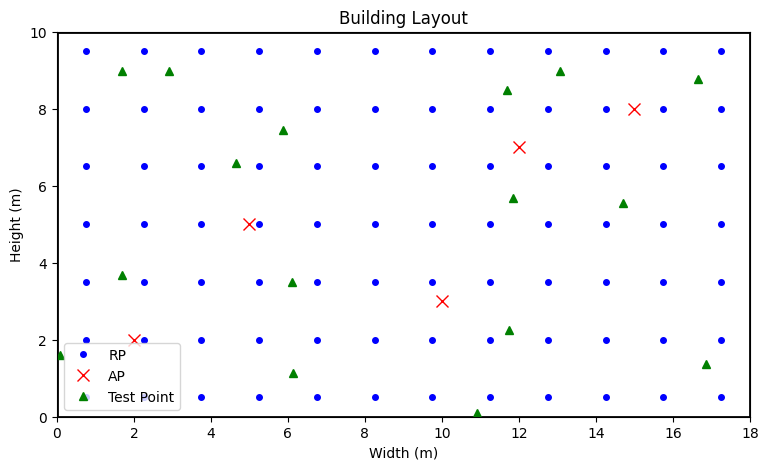

Exported Test RSS data to 'test_rss_values.csv'. Sample rows:
    TP_X  TP_Y   AP_1   AP_2   AP_3   AP_4   AP_5
0  16.86  1.38 -45.23 -43.50 -37.12 -36.74 -36.19
1   6.14  1.13 -30.87 -32.09 -29.74 -38.90 -35.55
2  16.64  8.77 -42.90 -43.47 -41.03 -32.96 -25.61
3   4.64  6.60 -33.06 -23.35 -36.35 -39.04 -43.42
4  14.71  5.55 -43.30 -38.05 -34.15 -32.24 -27.50
5   1.68  8.97 -36.10 -36.05 -39.90 -40.31 -44.80
6   6.10  3.49 -32.08 -24.31 -29.72 -34.63 -42.74
7  13.07  8.97 -44.21 -38.05 -35.51 -25.98 -18.98
8   2.91  8.99 -35.82 -30.80 -37.44 -38.07 -42.31
9  10.92  0.09 -37.68 -39.27 -30.17 -37.87 -38.82


In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def draw_building(width, height):
    fig, ax = plt.subplots(figsize=(width / 2, height / 2))
    ax.plot([0, width, width, 0, 0], [0, 0, height, height, 0], 'k-', linewidth=2)
    ax.set(xlim=(0, width), ylim=(0, height), aspect='equal')
    ax.set(xlabel='Width (m)', ylabel='Height (m)', title='Building Layout')
    return ax

def place_access_points(ax, access_points=[]):
    for i, ap in enumerate(access_points):
        ax.plot(ap[0], ap[1], 'rx', markersize=8, label='AP' if i == 0 else "")
    ax.legend()
    return access_points

def place_reference_points(ax, length, width, spacing):
    d_wx = (length % spacing) / 2
    n_RPx = length // spacing + 1
    d_wy = (width % spacing) / 2
    n_RPy = width // spacing + 1

    if d_wx == 0:
        d_wx = spacing / 2
        n_RPx -= 1
    if d_wy == 0:
        d_wy = spacing / 2
        n_RPy -= 1

    X = [d_wx + i * spacing for i in range(int(n_RPx))]
    Y = [d_wy + i * spacing for i in range(int(n_RPy))]
    XX, YY = np.meshgrid(X, Y)
    rp = np.column_stack((XX.ravel(), YY.ravel()))

    for i, (x, y) in enumerate(rp):
        ax.plot(x, y, 'bo', markersize=4, label='RP' if i == 0 else "")
    ax.legend()
    return rp

def generate_test_points(length, width, rps, test_ratio=0.2, min_distance=0.5):
    num_rps = rps.shape[0]
    num_test_points = max(1, int(num_rps * test_ratio))  # at least one test point

    test_points = []

    while len(test_points) < num_test_points:
        x = np.random.uniform(0, length)
        y = np.random.uniform(0, width)
        candidate = np.array([x, y])

        distances = np.linalg.norm(rps - candidate, axis=1)
        if np.all(distances >= min_distance):
            if test_points:
                test_dists = np.linalg.norm(np.array(test_points) - candidate, axis=1)
                if np.any(test_dists < min_distance):
                    continue
            test_points.append(candidate)

    test_points = np.array(test_points)
    test_points = np.round(test_points, 2)
    return test_points

def simulate_rss(aps, points, p_tx=-20, path_loss_exponent=2, noise_std=2):
    rss_matrix = []
    for point in points:
        row = []
        for ap in aps:
            distance = np.linalg.norm(np.array(ap) - np.array(point))
            if distance == 0:
                rss = p_tx
            else:
                rss = p_tx - 10 * path_loss_exponent * np.log10(distance)
            rss += np.random.normal(0, noise_std)
            row.append(rss)
        rss_matrix.append(row)
    return np.round(np.array(rss_matrix), 2)

def main():
    building_length = 18
    building_width = 10
    rp_spacing = 1.5
    access_points_coords = [(2, 2), (5, 5), (10, 3), (12, 7), (15, 8)]

    ax = draw_building(building_length, building_width)
    rp = place_reference_points(ax, building_length, building_width, rp_spacing)
    ap = place_access_points(ax, access_points_coords)

    tp = generate_test_points(building_length, building_width, rp, test_ratio=0.2, min_distance=0.5)
    for i, (x, y) in enumerate(tp):
        ax.plot(x, y, 'g^', markersize=6, label='Test Point' if i == 0 else "")
    ax.legend()
    plt.show()

    rss_tp_matrix = simulate_rss(ap, tp)

    df_tp = pd.DataFrame(rss_tp_matrix, columns=[f'AP_{i+1}' for i in range(len(ap))])
    df_tp.insert(0, 'TP_Y', tp[:, 1])
    df_tp.insert(0, 'TP_X', tp[:, 0])

    test_csv = 'test_rss_values.csv'
    df_tp.to_csv(test_csv, index=False)

    print(f"Exported Test RSS data to '{test_csv}'. Sample rows:")
    print(df_tp.head(10))

if __name__ == "__main__":
    main()


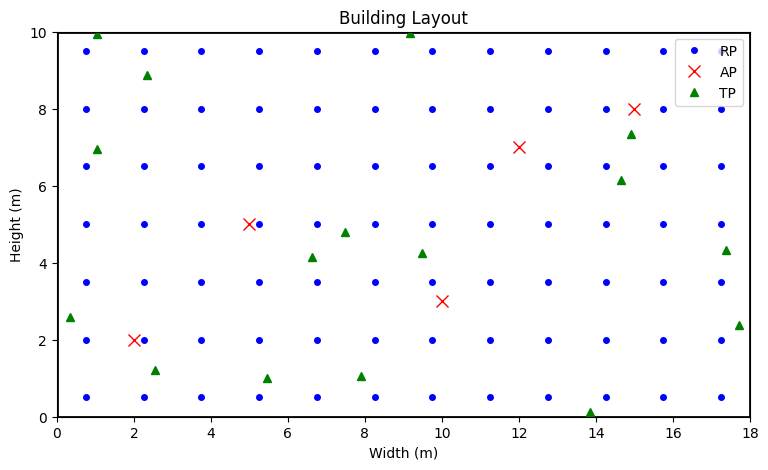

Exported RP RSS data to 'rp_rss_values.csv'. Sample rows:
    RP_X  RP_Y   AP_1   AP_2   AP_3   AP_4   AP_5
0   0.75   0.5 -26.90 -35.05 -42.59 -41.91 -44.17
1   2.25   0.5 -22.48 -34.20 -40.16 -38.98 -43.72
2   3.75   0.5 -27.31 -35.25 -37.45 -42.20 -42.97
3   5.25   0.5 -27.65 -35.82 -37.82 -36.49 -42.22
4   6.75   0.5 -35.28 -31.60 -33.47 -34.79 -39.59
5   8.25   0.5 -37.14 -30.57 -30.90 -36.02 -39.48
6   9.75   0.5 -35.34 -33.19 -27.94 -38.26 -38.31
7  11.25   0.5 -40.79 -33.70 -28.65 -37.05 -38.10
8  12.75   0.5 -43.41 -40.99 -29.00 -37.63 -39.97
9  14.25   0.5 -40.75 -37.87 -32.42 -34.76 -39.06

Exported TP RSS data to 'tp_rss_values.csv'. Sample rows:
    TP_X  TP_Y   AP_1   AP_2   AP_3   AP_4   AP_5
0  17.38  4.32 -45.06 -41.94 -38.36 -36.96 -35.65
1   7.91  1.06 -35.71 -36.81 -27.58 -37.00 -42.85
2   1.05  9.95 -38.69 -37.54 -40.45 -38.41 -46.73
3   1.04  6.95 -33.82 -33.22 -38.47 -40.37 -44.43
4  17.71  2.39 -44.56 -43.85 -35.62 -37.27 -32.09
5   2.56  1.21 -19.84 -34.50 -40.

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def draw_building(width, height):
    fig, ax = plt.subplots(figsize=(width / 2, height / 2))
    ax.plot([0, width, width, 0, 0], [0, 0, height, height, 0], 'k-', linewidth=2)
    ax.set(xlim=(0, width), ylim=(0, height), aspect='equal')
    ax.set(xlabel='Width (m)', ylabel='Height (m)', title='Building Layout')
    return ax

def place_access_points(ax, access_points=[]):
    for i, ap in enumerate(access_points):
        ax.plot(ap[0], ap[1], 'rx', markersize=8, label='AP' if i == 0 else "")
    ax.legend()
    return access_points

def place_reference_points(ax, length, width, spacing):
    d_wx = (length % spacing) / 2
    n_RPx = length // spacing + 1
    d_wy = (width % spacing) / 2
    n_RPy = width // spacing + 1

    if d_wx == 0:
        d_wx = spacing / 2
        n_RPx -= 1
    if d_wy == 0:
        d_wy = spacing / 2
        n_RPy -= 1

    X = [d_wx + i * spacing for i in range(int(n_RPx))]
    Y = [d_wy + i * spacing for i in range(int(n_RPy))]
    XX, YY = np.meshgrid(X, Y)
    rp = np.column_stack((XX.ravel(), YY.ravel()))

    for i, (x, y) in enumerate(rp):
        ax.plot(x, y, 'bo', markersize=4, label='RP' if i == 0 else "")
    ax.legend()
    return rp

def generate_test_points(length, width, rps, test_ratio=0.2, min_distance=0.5):
    num_rps = rps.shape[0]
    num_test_points = max(1, int(num_rps * test_ratio))  # at least one test point

    test_points = []
    while len(test_points) < num_test_points:
        x = np.random.uniform(0, length)
        y = np.random.uniform(0, width)
        candidate = np.array([x, y])

        distances = np.linalg.norm(rps - candidate, axis=1)
        if np.all(distances >= min_distance):
            if test_points:
                test_dists = np.linalg.norm(np.array(test_points) - candidate, axis=1)
                if np.any(test_dists < min_distance):
                    continue
            test_points.append(candidate)

    test_points = np.array(test_points)
    test_points = np.round(test_points, 2)
    return test_points

def simulate_rss(aps, points, p_tx=-20, path_loss_exponent=2, noise_std=2):
    rss_matrix = []
    for point in points:
        row = []
        for ap in aps:
            distance = np.linalg.norm(np.array(ap) - np.array(point))
            if distance == 0:
                rss = p_tx
            else:
                rss = p_tx - 10 * path_loss_exponent * np.log10(distance)
            rss += np.random.normal(0, noise_std)
            row.append(rss)
        rss_matrix.append(row)
    return np.round(np.array(rss_matrix), 2)

def main():
    building_length = 18
    building_width = 10
    rp_spacing = 1.5
    access_points_coords = [(2, 2), (5, 5), (10, 3), (12, 7), (15, 8)]

    ax = draw_building(building_length, building_width)
    rp = place_reference_points(ax, building_length, building_width, rp_spacing)
    ap = place_access_points(ax, access_points_coords)

    tp = generate_test_points(building_length, building_width, rp, test_ratio=0.2, min_distance=0.5)
    for i, (x, y) in enumerate(tp):
        ax.plot(x, y, 'g^', markersize=6, label='TP' if i == 0 else "")
    ax.legend()
    plt.show()

    # Simulate RSS for RPs and export
    rss_rp = simulate_rss(ap, rp)
    df_rp = pd.DataFrame(rss_rp, columns=[f'AP_{i+1}' for i in range(len(ap))])
    df_rp.insert(0, 'RP_Y', rp[:, 1])
    df_rp.insert(0, 'RP_X', rp[:, 0])
    rp_csv = 'rp_rss_values.csv'
    df_rp.to_csv(rp_csv, index=False)
    print(f"Exported RP RSS data to '{rp_csv}'. Sample rows:")
    print(df_rp.head(10))

    # Simulate RSS for TPs and export
    rss_tp = simulate_rss(ap, tp)
    df_tp = pd.DataFrame(rss_tp, columns=[f'AP_{i+1}' for i in range(len(ap))])
    df_tp.insert(0, 'TP_Y', tp[:, 1])
    df_tp.insert(0, 'TP_X', tp[:, 0])
    tp_csv = 'tp_rss_values.csv'
    df_tp.to_csv(tp_csv, index=False)
    print(f"\nExported TP RSS data to '{tp_csv}'. Sample rows:")
    print(df_tp.head(10))

if __name__ == "__main__":
    main()


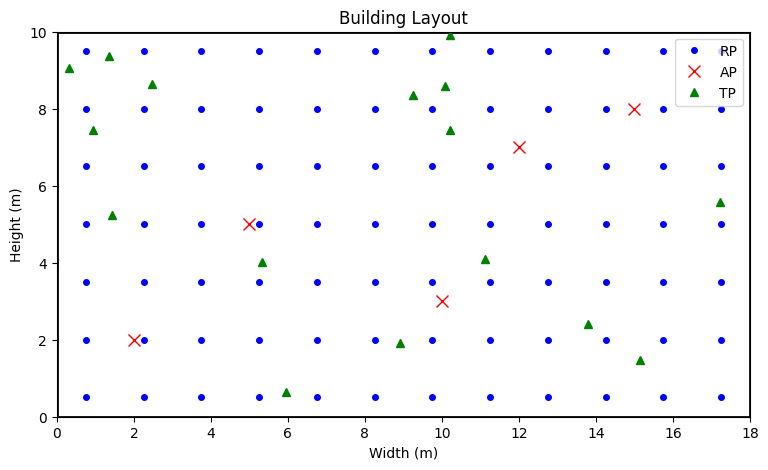

Exported AP coordinates to 'ap_coords.csv':
    AP_X  AP_Y
0     2     2
1     5     5
2    10     3
3    12     7
4    15     8 

Exported RP RSS data to 'rp_rss_values.csv'. Sample rows:
     RP_X  RP_Y   AP_1   AP_2   AP_3   AP_4   AP_5
0   0.75   0.5 -25.89 -33.21 -43.91 -42.24 -43.99
1   2.25   0.5 -23.86 -32.91 -36.04 -40.53 -43.63
2   3.75   0.5 -33.63 -29.58 -34.12 -40.16 -42.46
3   5.25   0.5 -31.03 -31.86 -34.57 -41.08 -39.73
4   6.75   0.5 -30.51 -33.16 -33.32 -35.66 -41.11
5   8.25   0.5 -31.71 -34.95 -28.49 -37.23 -41.53
6   9.75   0.5 -36.94 -36.07 -29.74 -38.14 -38.19
7  11.25   0.5 -38.58 -36.82 -26.96 -37.01 -44.40
8  12.75   0.5 -40.62 -43.92 -30.80 -36.53 -36.08
9  14.25   0.5 -39.05 -44.38 -30.90 -34.90 -41.47 

Exported TP RSS data to 'tp_rss_values.csv'. Sample rows:
     TP_X  TP_Y   AP_1   AP_2   AP_3   AP_4   AP_5
0   0.31  9.06 -38.88 -36.11 -40.91 -41.17 -41.90
1   9.26  8.36 -41.19 -33.79 -37.56 -28.02 -36.81
2   5.96  0.65 -32.07 -36.50 -34.34 -41.14 -40.78

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def draw_building(width, height):
    fig, ax = plt.subplots(figsize=(width / 2, height / 2))
    ax.plot([0, width, width, 0, 0], [0, 0, height, height, 0], 'k-', linewidth=2)
    ax.set(xlim=(0, width), ylim=(0, height), aspect='equal')
    ax.set(xlabel='Width (m)', ylabel='Height (m)', title='Building Layout')
    return ax

def place_access_points(ax, access_points=[]):
    for i, ap in enumerate(access_points):
        ax.plot(ap[0], ap[1], 'rx', markersize=8, label='AP' if i == 0 else "")
    ax.legend()
    return access_points

def place_reference_points(ax, length, width, spacing):
    d_wx = (length % spacing) / 2
    n_RPx = length // spacing + 1
    d_wy = (width % spacing) / 2
    n_RPy = width // spacing + 1

    if d_wx == 0:
        d_wx = spacing / 2
        n_RPx -= 1
    if d_wy == 0:
        d_wy = spacing / 2
        n_RPy -= 1

    X = [d_wx + i * spacing for i in range(int(n_RPx))]
    Y = [d_wy + i * spacing for i in range(int(n_RPy))]
    XX, YY = np.meshgrid(X, Y)
    rp = np.column_stack((XX.ravel(), YY.ravel()))

    for i, (x, y) in enumerate(rp):
        ax.plot(x, y, 'bo', markersize=4, label='RP' if i == 0 else "")
    ax.legend()
    return rp

def generate_test_points(length, width, rps, test_ratio=0.2, min_distance=0.5):
    num_rps = rps.shape[0]
    num_test_points = max(1, int(num_rps * test_ratio))
    test_points = []
    while len(test_points) < num_test_points:
        x = np.random.uniform(0, length)
        y = np.random.uniform(0, width)
        candidate = np.array([x, y])
        distances = np.linalg.norm(rps - candidate, axis=1)
        if np.all(distances >= min_distance):
            if test_points:
                test_dists = np.linalg.norm(np.array(test_points) - candidate, axis=1)
                if np.any(test_dists < min_distance):
                    continue
            test_points.append(candidate)
    test_points = np.round(np.array(test_points), 2)
    return test_points

def simulate_rss(aps, points, p_tx=-20, path_loss_exponent=2, noise_std=2):
    rss_matrix = []
    for point in points:
        row = []
        for ap in aps:
            distance = np.linalg.norm(np.array(ap) - np.array(point))
            rss = p_tx if distance == 0 else p_tx - 10 * path_loss_exponent * np.log10(distance)
            rss += np.random.normal(0, noise_std)
            row.append(rss)
        rss_matrix.append(row)
    return np.round(np.array(rss_matrix), 2)

def main():
    building_length = 18
    building_width = 10
    rp_spacing = 1.5
    access_points_coords = [(2, 2), (5, 5), (10, 3), (12, 7), (15, 8)]

    # 1) Draw map
    ax = draw_building(building_length, building_width)
    rp = place_reference_points(ax, building_length, building_width, rp_spacing)
    ap = place_access_points(ax, access_points_coords)

    # 2) Generate and plot test points
    tp = generate_test_points(building_length, building_width, rp, test_ratio=0.2, min_distance=0.5)
    for i, (x, y) in enumerate(tp):
        ax.plot(x, y, 'g^', markersize=6, label='TP' if i == 0 else "")
    ax.legend()
    plt.show()

    # 3) Export AP coordinates
    df_ap = pd.DataFrame(access_points_coords, columns=['AP_X', 'AP_Y'])
    ap_csv = 'ap_coords.csv'
    df_ap.to_csv(ap_csv, index=False)
    print(f"Exported AP coordinates to '{ap_csv}':\n", df_ap, "\n")

    # 4) Simulate & export RP RSS
    rss_rp = simulate_rss(ap, rp)
    df_rp = pd.DataFrame(rss_rp, columns=[f'AP_{i+1}' for i in range(len(ap))])
    df_rp.insert(0, 'RP_Y', rp[:, 1])
    df_rp.insert(0, 'RP_X', rp[:, 0])
    rp_csv = 'rp_rss_values.csv'
    df_rp.to_csv(rp_csv, index=False)
    print(f"Exported RP RSS data to '{rp_csv}'. Sample rows:\n", df_rp.head(10), "\n")

    # 5) Simulate & export TP RSS
    rss_tp = simulate_rss(ap, tp)
    df_tp = pd.DataFrame(rss_tp, columns=[f'AP_{i+1}' for i in range(len(ap))])
    df_tp.insert(0, 'TP_Y', tp[:, 1])
    df_tp.insert(0, 'TP_X', tp[:, 0])
    tp_csv = 'tp_rss_values.csv'
    df_tp.to_csv(tp_csv, index=False)
    print(f"Exported TP RSS data to '{tp_csv}'. Sample rows:\n", df_tp.head(10))

if __name__ == "__main__":
    main()


In [181]:
# localization_methods.py

import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans

# 1) Load data
rp_df = pd.read_csv('rp_rss_values.csv')    # columns: RP_X, RP_Y, AP_1, AP_2, …
tp_df = pd.read_csv('tp_rss_values.csv')    # columns: TP_X, TP_Y, AP_1, AP_2, …
ap_df = pd.read_csv('ap_coords.csv')        # columns: AP_X, AP_Y

# Features & targets
X_train = rp_df.filter(regex='^AP_').values
y_train = rp_df[['RP_X','RP_Y']].values
X_test  = tp_df.filter(regex='^AP_').values
y_test  = tp_df[['TP_X','TP_Y']].values

# Load AP coords as float array
ap_coords = ap_df[['AP_X','AP_Y']].values   # shape (N_AP, 2)

# Helper: mean Euclidean error
def mean_error(y_true, y_pred):
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

results = {}

# --- 2.1 Centroid (weighted by RSS) ---
def centroid_predict(rss_vec, ap_coords):
    w = np.maximum(rss_vec - rss_vec.min() + 1e-3, 0)
    return np.average(ap_coords, axis=0, weights=w)

y_pred = np.array([centroid_predict(x, ap_coords) for x in X_test])
results['Centroid'] = mean_error(y_test, y_pred)

# --- 2.2 Fingerprint k-NN Regression ---
knn = KNeighborsRegressor(n_neighbors=4, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
results['kNN'] = mean_error(y_test, y_pred)

# --- 2.3 Decision Tree Regressor ---
dt = DecisionTreeRegressor(max_depth=10)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
results['DecisionTree'] = mean_error(y_test, y_pred)

# --- 2.4 Support Vector Regression (SVR) ---
svr_x = SVR(); svr_y = SVR()
svr_x.fit(X_train, y_train[:,0]); svr_y.fit(X_train, y_train[:,1])
y_pred = np.vstack((svr_x.predict(X_test), svr_y.predict(X_test))).T
results['SVR'] = mean_error(y_test, y_pred)

# --- 2.5 Random Forest Regressor ---
rf = RandomForestRegressor(n_estimators=50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
results['RandomForest'] = mean_error(y_test, y_pred)

# --- 2.6 MLP Regressor (Neural Network) ---
mlp = MLPRegressor(hidden_layer_sizes=(50,50), max_iter=2500, learning_rate_init=0.005)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
results['MLP'] = mean_error(y_test, y_pred)

# --- 2.7 K-means (coarse clustering) ---
kmeans = KMeans(n_clusters=len(ap_coords), random_state=0)
kmeans.fit(X_train)
# Compute physical centroids of each RSS-space cluster
labels_train = kmeans.labels_
cluster_centroids_xy = np.zeros((kmeans.n_clusters, 2))
for k in range(kmeans.n_clusters):
    members = (labels_train == k)
    cluster_centroids_xy[k] = y_train[members].mean(axis=0)
# Predict cluster for each test vector and map to physical centroid
labels_test = kmeans.predict(X_test)
y_pred = cluster_centroids_xy[labels_test]
results['KMeans'] = mean_error(y_test, y_pred)


# 3) Report
print("Localization results (mean error in meters):")
for name, err in results.items():
    print(f" - {name:20s}: {err:.3f}")


Localization results (mean error in meters):
 - Centroid            : 3.840
 - kNN                 : 1.593
 - DecisionTree        : 3.192
 - SVR                 : 2.757
 - RandomForest        : 2.803
 - MLP                 : 2.650
 - KMeans              : 4.925
